## Outfit Matcher: AI Classified Skin Tone and Outfit Recommder

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
image_details_path = "/content/drive/MyDrive/Colab Notebooks/SGP/mst-e_image_details.csv"
golden_adversarial_path = "/content/drive/MyDrive/Colab Notebooks/SGP/golden_and_adversarial_mst-e_image_ids.csv"
image_details = pd.read_csv(image_details_path)
golden_adversarial = pd.read_csv(golden_adversarial_path)
golden_adversarial = golden_adversarial.rename(columns={"subject": "subject_name"})


In [ ]:
df_golden = pd.merge(image_details, golden_adversarial[["subject_name", "golden_image_id"]],
                     left_on=["subject_name", "image_ID"], right_on=["subject_name", "golden_image_id"], how="left")
df_golden = df_golden.drop(columns=["golden_image_id"])
df_not_ideal = pd.merge(image_details, golden_adversarial[["subject_name", "not_ideal_image_id"]],
                        left_on=["subject_name", "image_ID"], right_on=["subject_name", "not_ideal_image_id"], how="left")
df_not_ideal = df_not_ideal.drop(columns=["not_ideal_image_id"])

In [ ]:
import glob
IMAGE_DIR = "E:/mst-e_data/mst"
IMG_SIZE = 224
def load_and_preprocess_image(image_id):
    img_path = glob.glob(f"{IMAGE_DIR}/**/{image_id}.jpg", recursive=True)
    if len(img_path) == 0:
        return None  # Image not found
    img = cv2.imread(img_path[0])
    if img is None:
        return None
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0  # Normalize pixel values
    return img
df = pd.concat([df_golden, df_not_ideal], ignore_index=True)
df["image_array"] = df["image_ID"].apply(load_and_preprocess_image)
df = df.dropna(subset=["image_array"])
df = pd.concat([df_golden, df_not_ideal], ignore_index=True)
print("Columns in df:", df.columns)

Columns in df: Index(['image_ID', 'pose', 'lighting', 'mask', 'subject_name', 'MST'], dtype='object')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3092 entries, 0 to 3091
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_ID      3092 non-null   object
 1   pose          3092 non-null   object
 2   lighting      3092 non-null   object
 3   mask          3092 non-null   object
 4   subject_name  3092 non-null   object
 5   MST           3092 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 145.1+ KB


In [ ]:
skin_tone_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SGP/skin_tone.csv")

In [ ]:
print(df.columns)  # Should include 'subject_name'
print(skin_tone_df.columns)  # Should include 'subject_name'

Index(['image_ID', 'pose', 'lighting', 'mask', 'subject_name', 'MST'], dtype='object')
Index(['Skin_Tone', 'Subject_ID'], dtype='object')


In [ ]:
skin_tone_df.rename(columns={"subject_name": "Subject_ID","Skin Tone": "skin_tone"}, inplace=True)
df.columns = df.columns.str.lower()
skin_tone_df.columns = skin_tone_df.columns.str.lower()

In [ ]:
print(df.columns)  # Should include 'subject_name'
print(skin_tone_df.columns)  # Should include 'subject_name'

Index(['image_id', 'pose', 'lighting', 'mask', 'subject_name', 'mst'], dtype='object')
Index(['skin_tone', 'subject_id'], dtype='object')


In [ ]:
print(df["subject_name"].dtype, skin_tone_df["subject_id"].dtype)

object object


In [ ]:
df = pd.merge(df, skin_tone_df, left_on="subject_name", right_on="subject_id", how="left")
print(df["skin_tone"].isnull().sum())

0


## Loading the preprocess images

In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/SGP/Small_images'

In [ ]:
import numpy as np
import os
import PIL
from sklearn.preprocessing import LabelEncoder

dataset_path = "/content/drive/MyDrive/Colab Notebooks/SGP/Small_images"
IMG_SIZE = 224
images = []
labels = []
label_encoder = LabelEncoder()

for subject_id in os.listdir(dataset_path):
    subject_path = os.path.join(dataset_path, subject_id)
    if os.path.isdir(subject_path):
        for file_name in os.listdir(subject_path):
            if file_name.endswith(('.jpg', '.jpeg', '.png', '.dng')):
                image_path = os.path.join(subject_path, file_name)
                try:
                    img = PIL.Image.open(image_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
                    img_array = np.array(img) / 255.0

                    if img_array.shape == (IMG_SIZE, IMG_SIZE, 3):
                        images.append(img_array)
                        labels.append(subject_id)
                    else:
                        print(f"Skipping {image_path}, incorrect shape: {img_array.shape}")

                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")

images = np.array(images, dtype=np.float32)
labels = np.array(labels)

labels_encoded = label_encoder.fit_transform(labels)
from tensorflow.keras.utils import to_categorical
labels_categorical = to_categorical(labels_encoded)

print("X Data shape:", images.shape)  # Should be (num_samples, 224, 224, 3)
print("Y Labels shape:", labels_categorical.shape)  # Should match number of samples


X Data shape: (192, 224, 224, 3)
Y Labels shape: (192, 19)


In [ ]:
from tensorflow.keras.utils import to_categorical
labels_categorical = to_categorical(labels_encoded)

### Spilting the dataset

In [ ]:
print("Available columns:", df.columns)

Available columns: Index(['image_id', 'pose', 'lighting', 'mask', 'subject_name', 'mst',
       'skin_tone', 'subject_id'],
      dtype='object')


In [ ]:
print("Shape of DataFrame before filtering:", df.shape)
df = df.dropna(subset=["skin_tone"])
print("Shape of DataFrame after filtering:", df.shape)

Shape of DataFrame before filtering: (3092, 8)
Shape of DataFrame after filtering: (3092, 8)


In [ ]:
df.columns

Index(['image_id', 'pose', 'lighting', 'mask', 'subject_name', 'mst',
       'skin_tone', 'subject_id'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# CNN MODEL

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load MobileNetV2 (pretrained on ImageNet)
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet")

# Freeze base model layers
base_model.trainable = False

# Custom classification head
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)

# Update this to match your number of classes
num_classes = labels_categorical.shape[1]  # Should be 19
x = Dense(num_classes, activation="softmax")(x)  # Change from 10 to 19

# Build and compile model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print summary to confirm correct output shape
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 18,319,443 (69.88 MB)

 Trainable params: 16,061,459 (61.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
print("Number of unique labels:", len(np.unique(labels)))  # Should match 19

Number of unique labels: 19


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.1927 - loss: 11.1085 - val_accuracy: 0.7179 - val_loss: 3.3711
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.8301 - loss: 1.9057 - val_accuracy: 0.7179 - val_loss: 3.4878
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9183 - loss: 0.5219 - val_accuracy: 0.8205 - val_loss: 2.3978
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9835 - loss: 0.0872 - val_accuracy: 0.8974 - val_loss: 2.2739
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9796 - loss: 0.1863 - val_accuracy: 0.8974 - val_loss: 2.5165
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 2.4573e-04 - val_accuracy: 0.8718 - val_loss: 2.6240
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9844 - loss: 0.0831 - val_accuracy: 0.8718 - val_loss: 2.2212
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9887 - loss: 0.0502 - val_accuracy: 0.8718 - val_loss: 2.

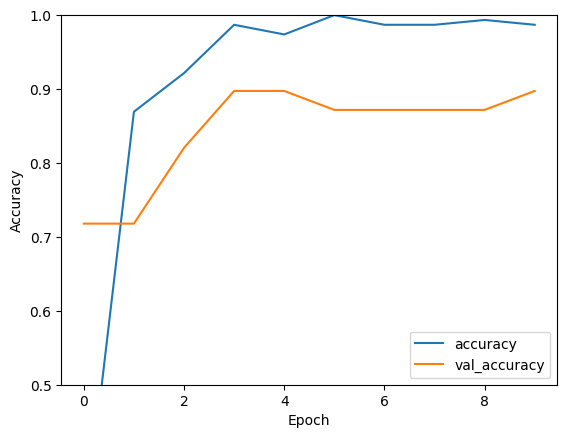

In [ ]:
# Assuming 'X_train', 'X_test', 'y_train', 'y_test' are defined from the previous code

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

# Testing

In [ ]:
import numpy as np
import tensorflow as tf
import PIL

def preprocess_image(image_path, img_size=224):
    """Load and preprocess an image for model prediction."""
    try:
        img = PIL.Image.open(image_path).convert("RGB")
        img = img.resize((img_size, img_size))  # Resize to match model input size
        img_array = np.array(img) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        return img_array
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

def predict_subject(image_path, model, label_encoder, df): # Add df as argument
    """Predict the subject from an image and retrieve subject_id from df."""
    img_array = preprocess_image(image_path)
    if img_array is None:
        return "Error: Could not load image."

    # Get model prediction
    prediction = model.predict(img_array)

    # Get class index with highest probability
    predicted_class_index = np.argmax(prediction, axis=1)[0]

    # Convert class index back to subject ID
    predicted_subject_id = label_encoder.inverse_transform([predicted_class_index])[0]

    # Get subject_id from df based on predicted subject ID
    # Convert both subject_name and predicted_subject_id to lowercase for case-insensitive comparison
    filtered_df = df[df['subject_name'].str.lower() == predicted_subject_id.lower()]

    if filtered_df.empty:
        print(f"Warning: Subject ID '{predicted_subject_id}' not found in DataFrame.")
        return None  # Or handle the case appropriately
    else:
        subject_id_from_df = filtered_df['subject_id'].iloc[0]
        return subject_id_from_df  # Return subject_id from df


# Example Usage:
image_path = "/content/drive/MyDrive/Colab Notebooks/SGP/TEST/Jesse Williams.jpg"  # Change this
predicted_subject = predict_subject(image_path, model, label_encoder, df) # Pass df to the function
print(f"Predicted Subject ID: {predicted_subject}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Subject ID: subject_2


In [ ]:
# # Save the Keras model
# model.save('my_model.h5')

# # Convert the model to TFLite
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the TFLite model to a file
# with open('my_model.tflite', 'wb') as f:
#   f.write(tflite_model)